In [21]:
# header
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import random
from typing import Tuple, Dict, List
from torchinfo import summary
from timeit import default_timer as timer
from tqdm.auto import tqdm
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = Path("data") / "Giraffe_lion"

In [35]:
# functions
def tensorprint(tensor):
    print("Shape: " , tensor.shape, " , Dimension: ", tensor.ndim , " \nDtype: ", tensor.dtype, " , Device: ", tensor.device)
    print("Max: ", tensor.amax(),f'[{tensor.argmax()}]', " , Min: ", tensor.amin(),f'[{tensor.argmin()}]')
    #print(tensor ,'\n')

def torch_rng():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

def print_time(start,end,device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def walk_through_dir(dir_path):
    """Walks Through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"directories: {len(dirnames)} | images: {len(filenames)} -> {dirpath}")

def display_random_images(dataset:torch.utils.data.Dataset,
                        classes: List[str] = None,
                        n: int =10,
                        display_shape: bool = True,
                        seed: int = None):
    if n > 10:
        n = 10
        display_shape = False

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k =n)
    plt.figure(figsize=(16,8))

    for i , tar_sample in enumerate(random_samples_idx):
        targ_image , targ_label = dataset[tar_sample][0], dataset[tar_sample][1]
        tar_image_adjust = targ_image.permute(1,2,0) # [CHW] -> [HWC]
        plt.subplot(1,n,i+1)
        plt.imshow(tar_image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {tar_image_adjust.shape}"
        plt.title(title)

def train_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn = accuracy_fn,
                device: torch.device = device):
    """Performs training on dataloader."""
    train_loss, train_acc = 0,0
    model.train()
    for X,y in dataloader:
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    #print(f"\nTrain loss: {train_loss:.4f} | Train acc: {train_acc:.2f}")
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                accuracy_fn = accuracy_fn,
                device: torch.device = device):
    """Performs testing on dataloader."""
    test_loss, test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred,y).item()
            test_acc += accuracy_fn(y,test_pred.argmax(dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    #print(f"\nTest loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
    return test_loss, test_acc

def train(model: torch.nn.Module,
            train_dataloader:torch.utils.data.DataLoader,
            test_dataloader:torch.utils.data.DataLoader,
            optimizer:torch.optim.Optimizer,
            loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
            epochs: int = 5,
            device = device):
    """Combines train_step and test_step function"""
    results = {"train_loss" : [],
                "train_acc" : [],
                "test_loss" : [],
                "test_acc"  : []}
    for epoch in tqdm(range(epochs)):
        train_loss , train_acc = train_step(model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss , test_acc = test_step    (model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)
        print(f"Epoch: {epoch} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of result dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    acc = results["train_acc"]
    test_acc = results["test_acc"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize = (15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label = "train_loss")
    plt.plot(epochs,test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs,acc,label ="train_accuracy")
    plt.plot(epochs,test_acc, label= "test_accuracy")
    plt.title("accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def pred_image(model: torch.nn.Module,
                image_path: str,
                class_names: List[str] = None,
                transform = None,
                device = device):
    """Make a prediction on a target image with a trained model"""
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255
    # add a batch size (NCHW)
    target_image = target_image.unsqueeze(0).to(device)
    if target_image.shape[1] != 3:
        target_image = target_image[:,:3,:,:]
    if transform:
        target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image_logits = model(target_image)
        target_image_probs = torch.softmax(target_image_logits.squeeze(), dim =0)
        target_image_pred = torch.argmax(target_image_probs, dim =0).cpu()
    

    return class_names[target_image_pred]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


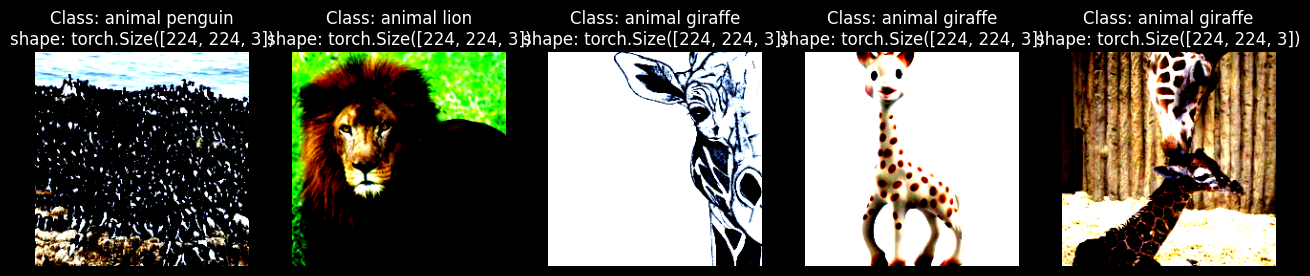

In [3]:
# data loading
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir  = image_path / "val"

weights = torchvision.models.VGG19_BN_Weights.DEFAULT
auto_transform = weights.transforms()
BATCH_SIZE = 32

train_data = datasets.ImageFolder(root=train_dir,
                                transform=auto_transform,  # transfrom for data
                                target_transform=None)      # transform target
test_data = datasets.ImageFolder(root=test_dir,
                                transform=auto_transform)                                

train_dataloader = DataLoader(dataset=train_data, 
                                batch_size=BATCH_SIZE,
                                shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

class_names = train_data.classes
class_dict = train_data.class_to_idx
train_target = train_data.targets
img_batch, label_batch = next(iter(train_dataloader))
display_random_images(train_data, class_names,n=5)

In [4]:
# Build model
model_5 = torchvision.models.vgg19_bn(weights = weights).to(device)
for i in model_5.features.parameters():
    i.requires_grad = False
model_5.classifier = torch.nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=3, bias=True)
).to(device)

summary(model_5,input_size=[32,3,224,224], col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VGG                                      [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 512, 7, 7]           --                        False
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 64, 224, 224]        (1,792)                   False
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        [32, 64, 224, 224]        (128)                     False
│    └─ReLU: 2-3                         [32, 64, 224, 224]        [32, 64, 224, 224]        --                        --
│    └─Conv2d: 2-4                       [32, 64, 224, 224]        [32, 64, 224, 224]        (36,928)                  False
│    └─BatchNorm2d: 2-5                  [32, 64, 224, 224]        [32, 64, 224, 224]        (128)                     Fal

In [5]:
# Train 
torch_rng()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(), lr = 0.003)
model5_results = train(model_5,train_dataloader,test_dataloader,optimizer,loss_fn,epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train acc: 78.44 | Test loss: 0.1956 | Test acc: 96.88
Epoch: 1 | Train acc: 96.95 | Test loss: 0.4765 | Test acc: 95.74
Epoch: 2 | Train acc: 96.52 | Test loss: 0.5238 | Test acc: 96.31
Epoch: 3 | Train acc: 97.97 | Test loss: 0.3403 | Test acc: 98.15
Epoch: 4 | Train acc: 98.36 | Test loss: 1.2377 | Test acc: 94.46


In [13]:
# Predict
val_giraffe = val_dir / "animal giraffe"
val_lion = val_dir / "animal lion"
val_penguin = val_dir / "animal penguin"

val_list = [val_giraffe, val_lion, val_penguin]
result = []
c = 0
for i in val_list:
    for filename in os.listdir(i):
        vd = i / filename
        pred = pred_image(model_5,vd, class_names,auto_transform,'cuda')
        result.append(pred)
        if pred != class_names[c]:
            print(filename,"->" ,i)
    c +=1

torch.Size([3, 683, 1024])
torch.Size([1, 3, 683, 1024])
torch.Size([3, 235, 350])
torch.Size([1, 3, 235, 350])
torch.Size([3, 430, 306])
torch.Size([1, 3, 430, 306])
torch.Size([3, 360, 640])
torch.Size([1, 3, 360, 640])
torch.Size([3, 1024, 931])
torch.Size([1, 3, 1024, 931])
torch.Size([3, 426, 640])
torch.Size([1, 3, 426, 640])
torch.Size([3, 350, 620])
torch.Size([1, 3, 350, 620])
torch.Size([3, 640, 640])
torch.Size([1, 3, 640, 640])
torch.Size([3, 683, 1024])
torch.Size([1, 3, 683, 1024])
torch.Size([3, 529, 640])
torch.Size([1, 3, 529, 640])
torch.Size([3, 683, 1024])
torch.Size([1, 3, 683, 1024])
torch.Size([3, 1024, 658])
torch.Size([1, 3, 1024, 658])
torch.Size([3, 661, 1024])
torch.Size([1, 3, 661, 1024])
torch.Size([3, 284, 170])
torch.Size([1, 3, 284, 170])
torch.Size([3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([3, 360, 640])
torch.Size([1, 3, 360, 640])
torch.Size([3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([3, 360, 640])
torch.Size([1, 3, 360, 

In [8]:
# Save
MODEL_PATH = Path("Models")
# MODEL_PATH.mkdir(parents= True, exist_ok =True)
MODEL_NAME = "02_Giraffe_Lion_Penguin.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
path_rel = r'C:\Users\earle\PythonMLenv\env\projects\Models\02_Giraffe_Lion_Penguin.pt'
model_5.load_state_dict(torch.load(path_rel))
model_5.eval()
# torch.save(model_5, MODEL_SAVE_PATH)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

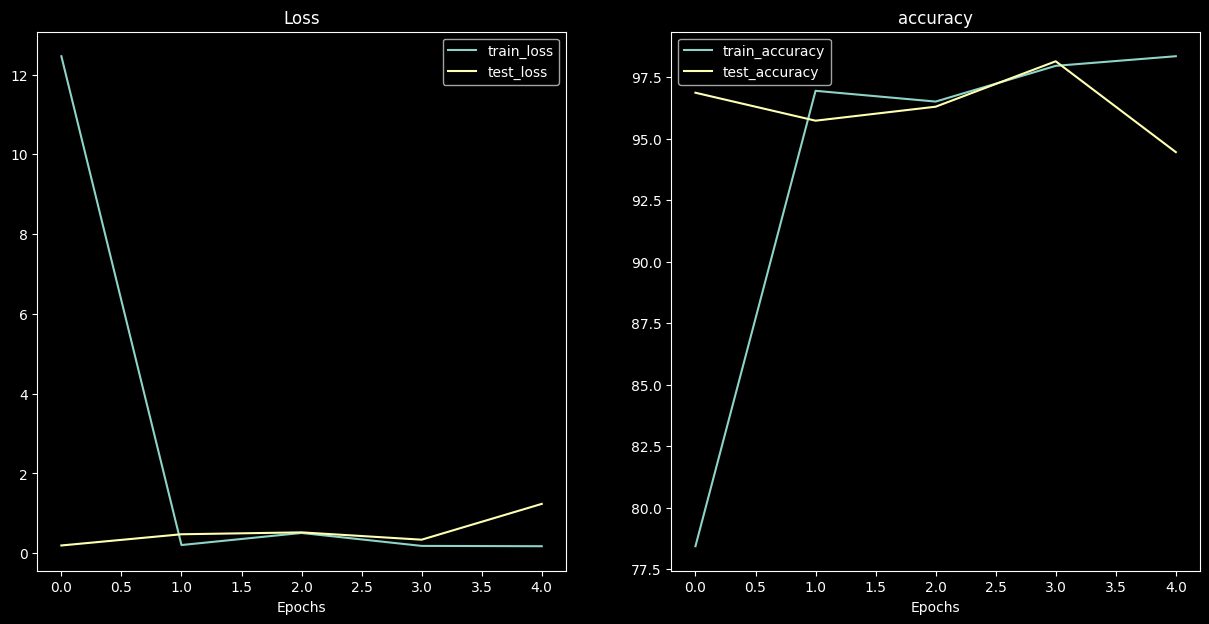

In [12]:
# loss curve
plot_loss_curves(model5_results)